In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/cats vs dogs.zip'

In [ ]:
# Directory that holds the data
DATA_DIR = './PetImages'

# Subdirectories for each class
data_dir_dogs = os.path.join(DATA_DIR, 'Dog')
data_dir_cats = os.path.join(DATA_DIR, 'Cat')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_dogs))} images of dogs.")
print(f"There are {len(os.listdir(data_dir_cats))} images of cats.")

There are 12499 images of dogs.
There are 12499 images of cats.


In [ ]:


removed_count = 0
for file_path in os.listdir(data_dir_dogs):
    try:
        fpath = os.path.join(data_dir_dogs, file_path)
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
        fobj.close()
    if not is_jfif:
        removed_count += 1
        os.remove(fpath)

for file_path in os.listdir(data_dir_cats):
    try:
        fpath = os.path.join(data_dir_cats, file_path)
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
        fobj.close()
    if not is_jfif:
        removed_count += 1
        os.remove(fpath)

print(f"Removed {removed_count} images")
print(f"There are {len(os.listdir(data_dir_dogs))} images of dogs after cleaning.")
print(f"There are {len(os.listdir(data_dir_cats))} images of cats after cleaning.")

Removed 1588 images
There are 11669 images of dogs after cleaning.
There are 11741 images of cats after cleaning.


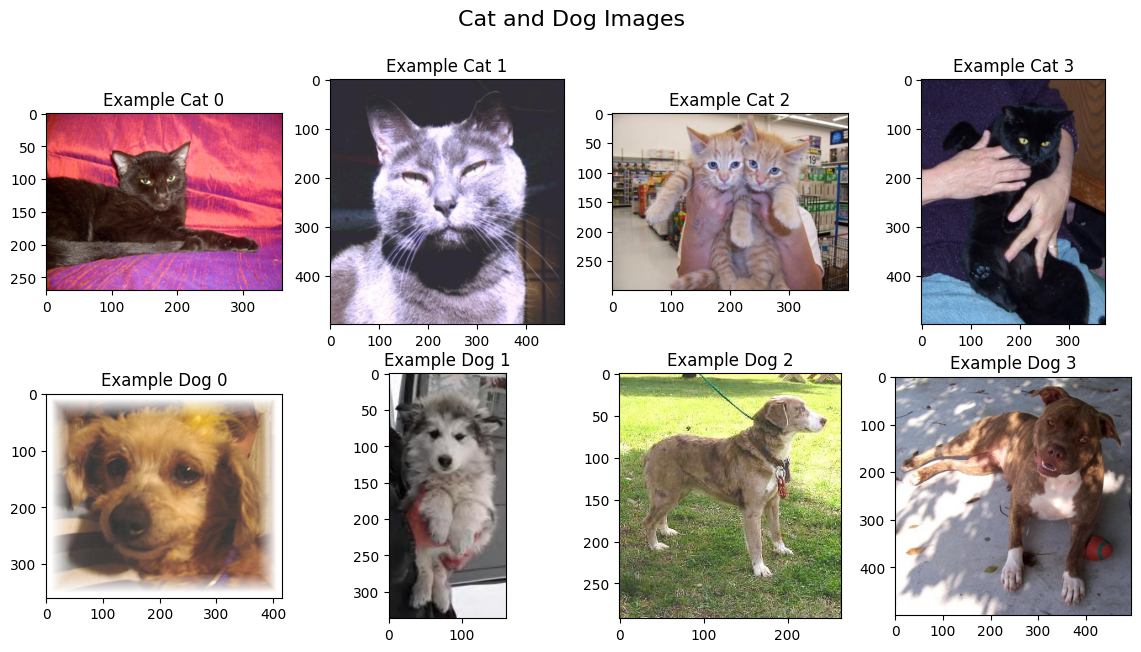

In [ ]:
# Get the filenames for cats and dogs images
cats_filenames = [os.path.join(data_dir_cats, filename) for filename in os.listdir(data_dir_cats)]
dogs_filenames = [os.path.join(data_dir_dogs, filename) for filename in os.listdir(data_dir_dogs)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cat and Dog Images', fontsize=16)

# Plot the first 4 images of each class
for i, cat_image in enumerate(cats_filenames[:4]):
    img = tf.keras.utils.load_img(cat_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cat {i}')

for i, dog_image in enumerate(dogs_filenames[:4]):
    img = tf.keras.utils.load_img(dog_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dog {i}')

plt.show()

In [ ]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    ### START CODE HERE ###

    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(150,150),
        batch_size=128,
        label_mode='binary',
        validation_split=0.2,
        subset='training',
        seed=42
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(150,150),
        batch_size=128,
        label_mode='binary',
        validation_split=0.2,
        subset='validation',
        seed=42
    )


    ### END CODE HERE ###

    return training_dataset, validation_dataset

In [ ]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [ ]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 150, 150, 3)
Shape of batch of labels: (128, 1)


In [ ]:
# GRADED FUNCTION: create_model

def create_model():
    """Creates the untrained model for classifying cats and dogs.

    Returns:
        tf.keras.Model: The model that will be trained to classify cats and dogs.
    """

    ### START CODE HERE ###

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(150,150,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
	)

    ### END CODE HERE ###

    return model

In [ ]:
# Create the compiled but untrained model
model = create_model()


In [ ]:
# GRADED CLASS: EarlyStoppingCallback

### START CODE HERE ###

# Remember to inherit from the correct class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs={}):
        # Check if the accuracy is greater or equal to 0.95 and validation accuracy is greater or equal to 0.8
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.80:
            print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")
            self.model.stop_training = True

### END CODE HERE ###

In [ ]:
# Train the model and save the training history (this may take some time)
history = model.fit(
	training_dataset,
	epochs=15,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 206ms/step - accuracy: 0.5475 - loss: 0.7277 - val_accuracy: 0.7208 - val_loss: 0.5732
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.6844 - loss: 0.5920 - val_accuracy: 0.7012 - val_loss: 0.5726
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.7270 - loss: 0.5351 - val_accuracy: 0.7574 - val_loss: 0.4914
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.7610 - loss: 0.4899 - val_accuracy: 0.7206 - val_loss: 0.5483
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.7852 - loss: 0.4475 - val_accuracy: 0.7911 - val_loss: 0.4449
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.8120 - loss: 0.4028 - val_accuracy: 0.7802 - val_loss: 0.4647
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.8333 - loss: 0.3645 - val_accuracy: 0.8088 - val_loss: 0.4265
Epoch 8/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.8645 - loss: 0

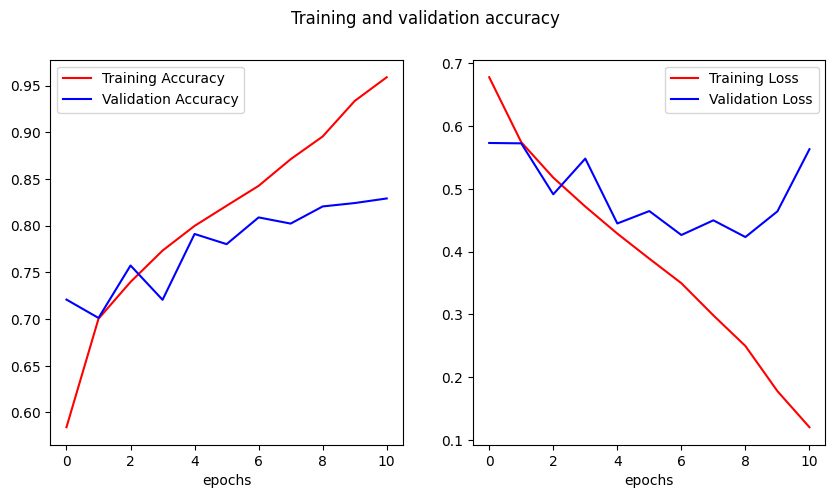

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()